In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import mixture
from scipy.integrate import quad, dblquad
from IPython.display import Image
plt.rcParams['figure.figsize'] = (12.0, 8.0) 

## Weak Gravitational Lensing
Bending of light by nearby mass is gravitational lensing. In the weak lensing regime this deflection is impossible to detect in a single background source. However, the presence of the foreground mass can be detected, as a  systematic alignment of background sources around the lensing mass. Weak gravitational lensing is thus an intrinsically statistical measurement.
<img src="exp_1.png">
## Measuring Shape
The reduced shear describes the shape distortion is described by a 2-component quantity, most conveniently written as a complex number $g$. 
However, galaxies are not intrinsically round, so that the observed ellipticity is a combination of intrinsic ellipticity and shear.
### Reduced Shear:  $g=g_1+ig_2=|g|e^{i2\phi}$  ;       Intrinsic ellipticity: $e=e_1+ie_2=|e|e^{i2\beta}$ 


### Observed shape: $e^{obs}=\frac{e+g}{1+g^*e}$

Estimating the (reduced) shear:  We make the assumption that the intrinsic orientation of galaxies ($e$) is random $<e>$=0
If |g|<1 :  $<e_{obs}>=g $

## Aim of project : Measure the instrinsic ellipticity distribution of galaxies from observed shape distribution
The intrinsic shape distribution in modelled as a Gaussian Mixture Model(GMM)

### $Pr(e)=\Sigma_i^{N_g} w_i \mathcal{N}(\mu_i,\sigma_i)$

Observed shapes  catalog of 10000 galaxies measured in the Great3 challenge is taken as the input data


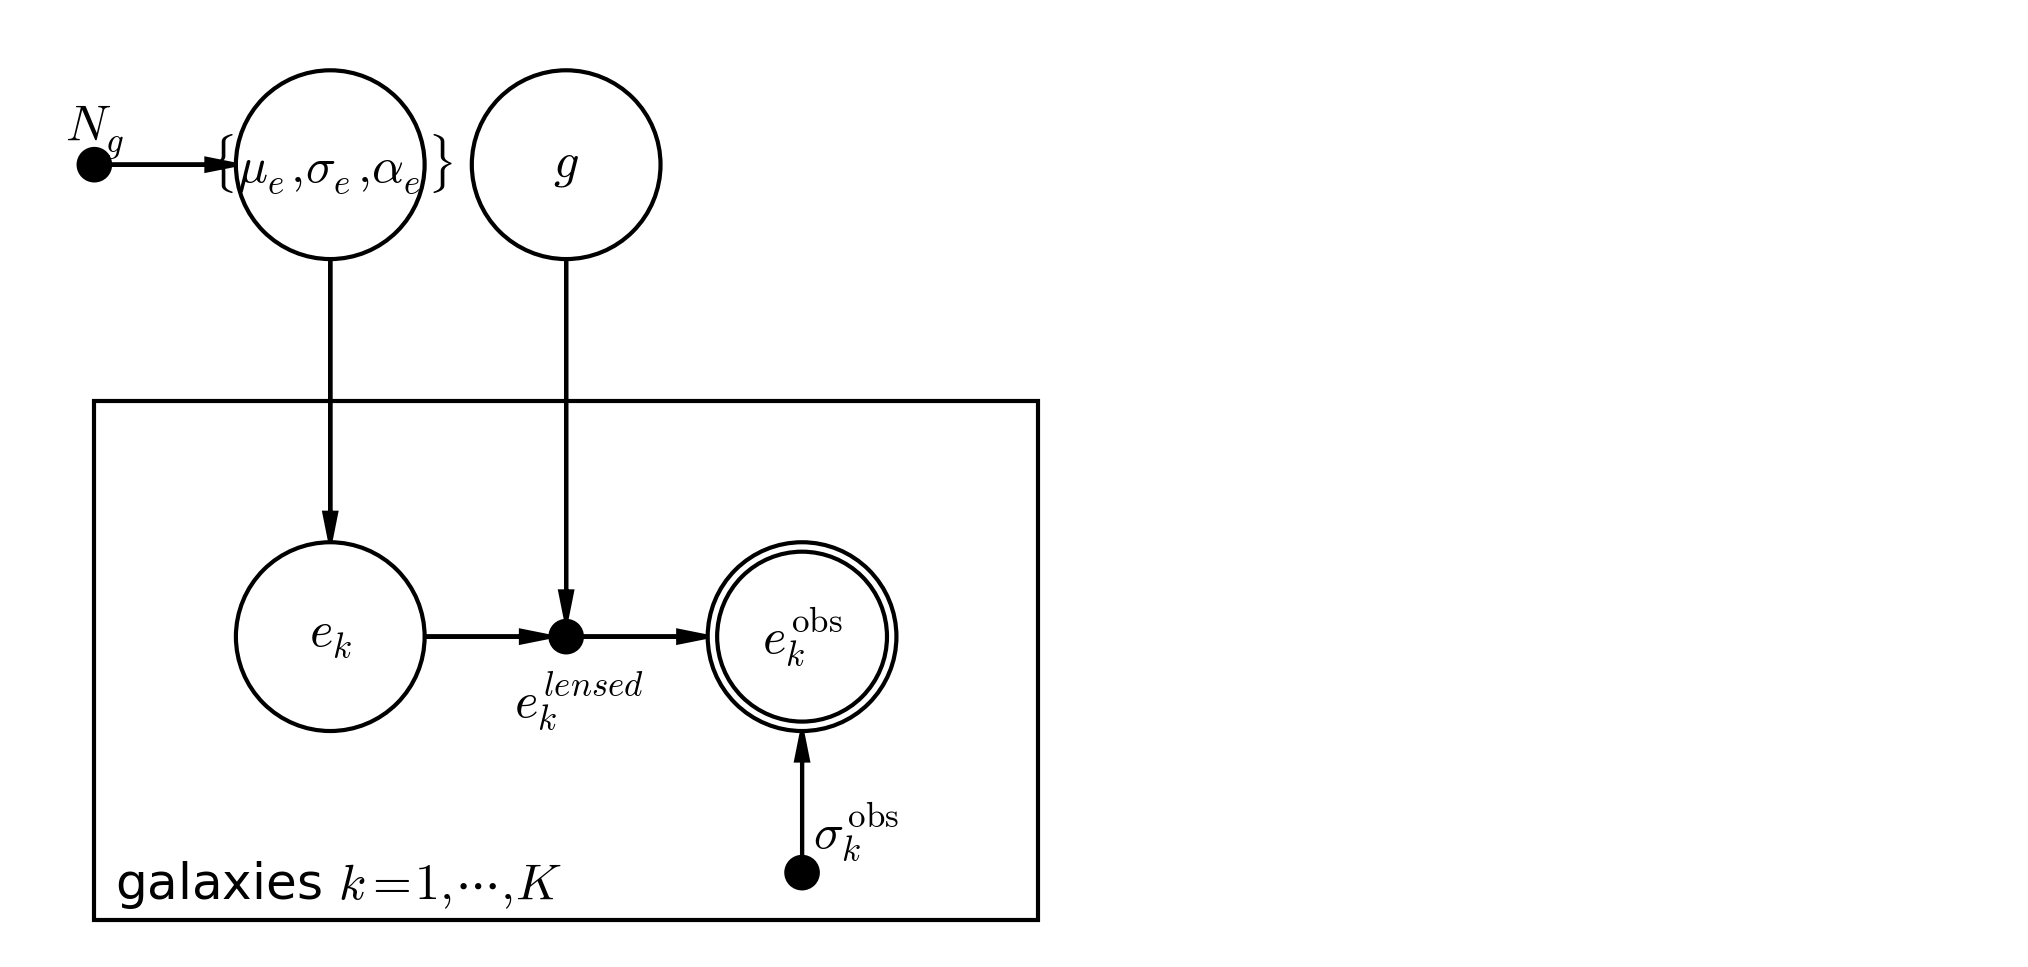

In [6]:
# Display:


Image(filename="flubber_PGM.png",width=800)

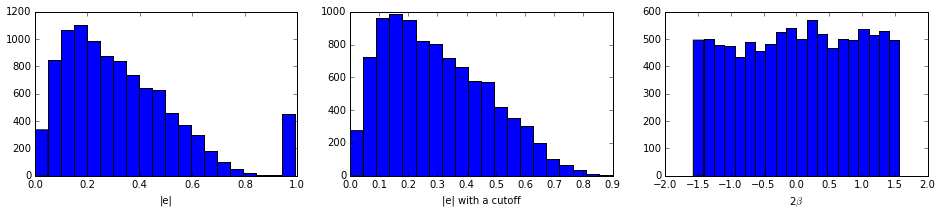

In [51]:
data=np.loadtxt('gr3_e.dat')
e=(data[0]**2+data[1]**2)**0.5
p,=np.where(e<=0.9)
e_cutoff=e[p]
theta=np.arctan(data[1]/data[0])
plt.figure(figsize=[16,10])
plt.subplot(3,3,1)
plt.hist(e,20)
plt.xlabel('|e|')
plt.subplot(3,3,2)
plt.hist(e_cutoff,20)
plt.xlabel('|e| with a cutoff')
plt.subplot(3,3,3)
plt.hist(theta,20)
plt.xlabel(r'2$\beta $')
plt.show()


The spike at 1 is due to improper fit as $|e|>1$ is unphysical. So a cutoff is applied at |e|=0.9

In [28]:


def create_gmm(gmm_param, eobs):
    sum=0
    x=np.linspace(0,max(eobs),len(eobs))
    for i in range(len(gmm_param.means)):
        sum+=gmm_param.weights[i]*np.exp(-((x-gmm_param.means[i])**2)/(2*gmm_param.covars[i]))/((2*np.pi*gmm_param.covars[i])**0.5)
    return sum

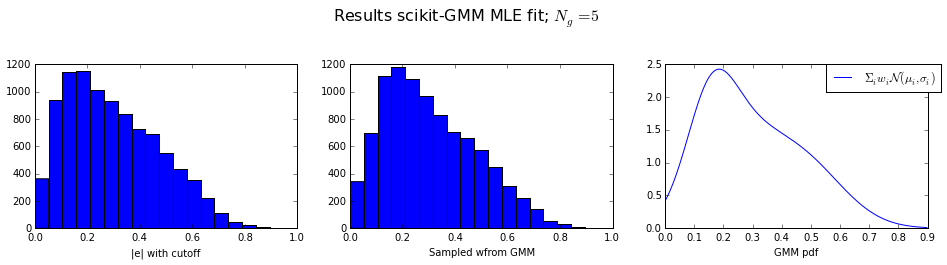

In [73]:
g=mixture.GMM(n_components=5)
m1=g.fit((np.array([e])).T) 
out=m1.sample(len(e))
m2=g.fit((np.array([e_cutoff])).T) 
out2=m2.sample(len(e_cutoff))
class gmm_param:
    def __init__(self,means=m2.means_.T[0], 
                 covars=m2.covars_.T[0],
                weights=m2.weights_):
        self.means=means
        self.weights=weights
        self.covars=covars

samp=gmm_param()
d=create_gmm(samp, e_cutoff)
x=np.linspace(0,max(e_cutoff),len(e_cutoff))
plt.figure(figsize=[16,10])

plt.subplot(3,3,1)
plt.hist(e_cutoff,np.linspace(0,1,20))
plt.xlabel('|e| with cutoff')
plt.subplot(3,3,2)
plt.hist(out2,np.linspace(0,1,20))
plt.xlabel('Sampled wfrom GMM')
plt.subplot(3,3,3)
plt.plot(x,d,label=r'$\Sigma_i w_i \mathcal{N}(\mu_i,\sigma_i)$')
plt.xlabel('GMM pdf')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.suptitle('Results scikit-GMM MLE fit; $N_g=5$',size=16)
plt.show()


#### Sampling distribution for the kth datapoint, $Pr(e^{obs}_k|e^{lens}_k)$
We choose a Gaussian sampling distribution (with error $\sigma_k$ constant for now):
$Pr(e^{obs}_k|e^{lens}_k,\sigma_k)=\frac{1}{\sqrt{2\pi}\sigma k} e^\frac{−(e^{obs}_k−e^{lens}_k)^2}{2\sigma_k^2}$

#### $Pr(e^{obs}|e^{lens},\sigma)=\Pi_k\frac{1}{\sqrt{2\pi}\sigma_k} e^\frac{−(e^{obs}_k−e^{lens}_k)^2}{2\sigma_k^2}$

#### Conditional PDF $Pr(e^{lens}_k|\{w_i^g,\sigma_i^g,\mu_i^g\},g)$
$Pr(e^{lens}_k|e_k,g)=\delta (e^{lens}_k−\frac{e_k+g}{1+g^*e_k})$ and  $Pr(e_k|\{w_i,\sigma_i,\mu_i\})=\Sigma_i^{N_g} w_i^g \mathcal{N}(\mu_i^g,\sigma_i^g)$


For the pdf to be analytical we assume that $g<<e$ and $e^{obs}_k=e_k+g$

$Pr(e^{lens}_k|e_k,g)=\delta (e^{lens}_k−(e_k+g))$ 

###  Joint likelihood, $Pr(e^{obs}|\{w_i^g,\sigma_i^g,\mu_i^g\},g)$ 
\begin{align}
Pr(e^{obs}|\{w_i,\sigma_i,\mu_i\},g) & = \prod_{k} \int \int Pr(e^{obs}_k|e^{lens}_k) \times Pr(e^{lens}_k|e_k,g) \times  Pr(e_k|\{w_i^g,\sigma_i^g,\mu_i^g\}) \,de_k \,de^{lens}_k\\
                                     & = \prod_{k} \int \int  Pr(e^{obs}_k|e^{lens}_k) \times  \delta (e^{lens}_k−(e_k+g)) \times  Pr(e_k|\{w_i^g,\sigma_i^g,\mu_i^g\}) \,de_k \,de^{lens}_k\\
                                     & = \prod_{k}  \int  \frac{1}{\sqrt{2\pi}\sigma k} e^\frac{−(e^{obs}_k−(e_k+g))^2}{2\sigma_k^2} \times  \sum_i^{N_g} w_i^g \mathcal{N}(\mu_i^g,\sigma_i^g)de_k \\
                                     & = \prod_{k}  \int  \mathcal{N}((e^{obs}_k-g),\sigma_k) \times  \sum_i^{N_g} w_i^g \mathcal{N}(\mu_i^g,\sigma_i^g)de_k \\
                                     & = \prod_{k} \sum_i^{N_g} \int  \mathcal{N}((e^{obs}_k-g),\sigma_k) \times   w_i^g \mathcal{N}(\mu_i^g,\sigma_i^g)de_k \\   
                                     & = \prod_{k} \sum_i^{N_g} \mathcal{N}(\mu_i^g+g,\sqrt{\sigma_k^2+{\sigma_i^g}^2}) \\ 
\end{align}         

The multiplication of two gaussian functions is another gaussian function (although no longer normalized)

In [102]:
def gaussian(x,mu,sigma):
    return np.exp(-((x-mu)**2)/(2*sigma**2))/((2.*np.pi*sigma**2)**0.5)

In [191]:
np.random.seed(1)

def log_prior_g(g):
    gmin,gmax=-1.,1.
    if ((g>=gmin) and (g<=gmax)) :
        return np.log(1/(gmax-gmin))
    else:
        return -np.inf
def log_prior_gmm(gmm_param):
    gmm_param.means = np.array(gmm_param.means)
    N=len(gmm_param.means)
    means_min,means_max=0.,1.
    covars_min,covars_max=0.,1.
    weights_min,weights_max=0.,1.
    q=np.where((gmm_param.means<=means_max)& (gmm_param.means>=means_min) & 
               (gmm_param.covars<=covars_max) & (gmm_param.covars>=covars_min) & 
               (gmm_param.weights>=weights_min) & (gmm_param.weights<=weights_max) )
    if len(q[0])==len(gmm_param.weights):
        return np.log(1/((means_max-means_min)*(covars_max-covars_min)*(weights_max-weights_min)))
    else : 
        return -np.inf

def log_likelihood(eobs,gmm_param,g,sigmak):
    val=0
    for i in range(len(gmm_param.means)):
        C=(sigmak**2+gmm_param.covars[i])
        print C
        val+= np.exp(-((-eobs+g+gmm_param.means[i])**2)/(2*C))*gmm_param.weights[i]/(2*np.pi*C)**0.5
        #print val
    #print np.sum(np.log(val))
    #return np.sum(np.log(val))
    return val
    
def log_likelihood2(eobs,gmm_param,g,sigmak):
    val=0
    for i in range(len(gmm_param.means)):
        C=(sigmak**2+gmm_param.covars[i])
        val+= gaussian(eobs,gmm_param.means[i]+g,C**0.5)*gmm_param.weights[i]
    #print np.sum(np.log(val))
    #return np.sum(np.log(val))
    return val

In [119]:
log_likelihood(np.array([.1]),samp,0.04,0.3)

0.112831937204
0.0968197665186
0.107150373332
0.115668089133
0.103329524199


-0.079340398187732281

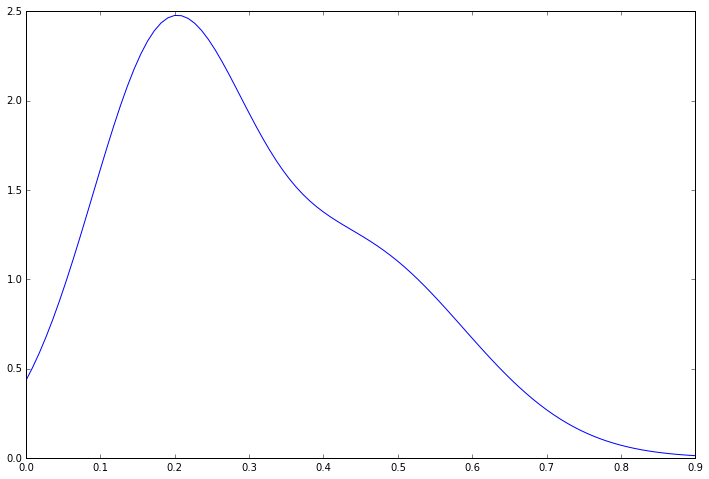

In [192]:
x=np.linspace(0,0.9,100)
y=log_likelihood2(x,input_param,0,0)
plt.plot(x,y)

In [ ]:
def log_likelihood3(eobs,gmm_param,g,sigmak):
    val=0
    for i in range(len(gmm_param.means)):
        C=(1/sigmak**2+1/gmm_param.covars[i])**-1
        M=(C/sigmak**2)*(g+eobs)+(C/gmm_param.covars[i])*(gmm_param.means[i])
        Z=gaussian(-g+eobs,gmm_param.means[i]* sigmak**2/gmm_param.covars[i] ,sigmak**4/C)
        val+= gmm_param.covars[i]*Z
        print gmm_param.means.shape
    print np.prod(val)
    return np.sum(np.log(val))

In [513]:
input_param.means

array([ 0.22194261,  0.41467807,  0.33195332,  0.15225158,  0.51195389])

In [429]:
C=(sigmak**2+gmm_param.covars[i])**0.5
1/(2*np.pi)**0.5*np.exp(-(eobs+g+gmm_param.means[i])**2/(2*(sigmak**2+gmm_param.covars[i])))*gmm_param.weights[i]/C

AttributeError: class gmm_param has no attribute 'covars'

-70.3514466378
-73.2431695839


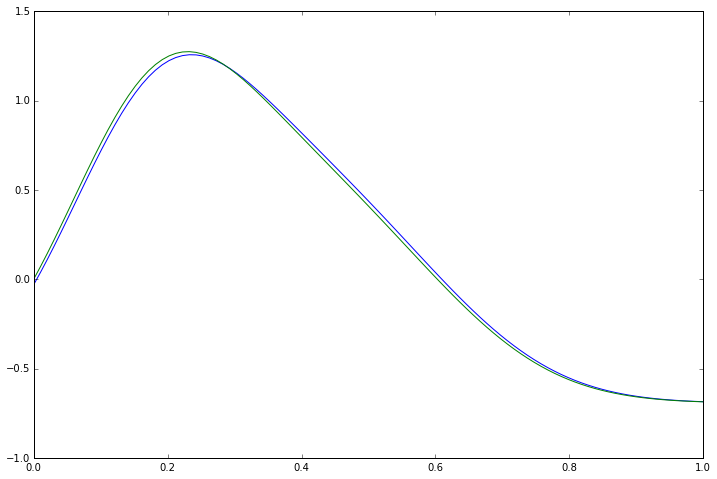

In [532]:
param2=gmm_param(means=[ 0.22,  0.425,  0.33195332,  0.16225158,  0.51195389])
x1=np.linspace(0,1,100)
y1=log_posterior2(x1,input_param,g,sigmak)
y2=log_posterior2(x1,param2,0,sigmak)
plt.plot(x1,y1)
plt.plot(x1,y2)

In [535]:
param2=gmm_param(means=[ 0.2,  0.4,  0.3,  0.15,  0.5])
log_likelihood2(eobs,param2,g,sigmak),log_posterior2(eobs,input_param,g,sigmak)

894.592759622
1020.84049842


(array([ 1.89651645,  0.41121385,  1.33284304, ...,  1.92437825,
         1.57795574,  0.6914039 ]),
 array([ 1.10739639, -0.22299127,  0.71536083, ...,  1.13944163,
         0.77205031,  0.07686278]))

In [304]:
input_param=gmm_param(means=[0.1,0.1,0.1,0.1,0.1])

print log_prior_gmm(input_param), log_posterior1(eobs,input_param,g,sigmak)

[0.1, 0.1, 0.1, 0.1, 0.1] (array([], dtype=int64),)
-inf [0.1, 0.1, 0.1, 0.1, 0.1] (array([], dtype=int64),)
-inf


In [253]:
def log_posterior1(eobs,gmm_param,g,sigmak):

    return log_likelihood1(eobs,gmm_param,g,sigmak)+log_prior_g(g)+log_prior_gmm(gmm_param)

In [162]:
def log_posterior2(eobs,gmm_param,g,sigmak):

    return log_likelihood2(eobs,gmm_param,g,sigmak)+log_prior_g(g)+log_prior_gmm(gmm_param)

In [181]:

def metropolis( eobs,gmm_param1,g,sigmak, g_stepsize,
               m_stepsize,w_stepsize,c_stepsize,nsteps=1000):
    
    log_prob = log_posterior2(eobs,gmm_param1,g,sigmak)
    #print log_prob
    
    # Store Markov chain as an array of samples:
    chain,m,s,w,log_probs = [],[],[],[],[]
    
    # Count our accepted proposals:
    naccept = 0
    t=0
    for i in range(nsteps):
        g_new = g + g_stepsize * np.random.random()        
        mean_new    = np.array(gmm_param1.means   + m_stepsize*np.random.rand())
        var_new     = np.array(gmm_param1.covars  + c_stepsize*np.random.rand())
        weight_new  = np.array(gmm_param1.weights + w_stepsize*np.random.rand())
        weight_new[-1]=1-(np.sum(weight_new[:-1]))
        #print mean_new
        
        gmm_new=gmm_param(means=mean_new,covars=var_new, weights=weight_new)
        log_prob_new = log_posterior2(eobs,gmm_new,g_new,sigmak)
        #print log_prob_new,log_prob    
        if np.log(np.random.rand()) < (log_prob_new - log_prob):
            # accept, and move to the proposed position:
            gmm_param1=gmm_new
            g = g_new
            log_prob = log_prob_new
            naccept += 1
            
            chain.append(g)
            m.append(gmm_param1.means)
            s.append(gmm_param1.covars)
            w.append(gmm_param1.weights)
            log_probs.append(log_prob)
        else:
            # reject, and store the same sample as before:
            pass
        chain.append(g)
        m.append(gmm_param1.means)
        s.append(gmm_param1.covars)
        w.append(gmm_param1.weights)
        log_probs.append(log_prob)

        
    acceptance_rate = naccept/float(nsteps) 
    print 'Acceptance Ratio:',acceptance_rate,t
    return chain,m,s,w,log_probs

In [166]:
np.log(np.random.rand())

-1.343315412774222

In [182]:
g=mixture.GMM(n_components=2)
m2=g.fit((np.array([e_cutoff])).T) 
class gmm_param:
    def __init__(self,means=m2.means_.T[0], 
                 covars=m2.covars_.T[0],
                weights=m2.weights_):
        self.means=means
        self.weights=weights
        self.covars=covars

In [170]:
input_param.means,input_param.covars,input_param.weights


(array([ 0.29901309]), array([ 0.03195447]), array([ 1.]))

In [188]:
eobs=e
sigmak=0
g=0.04
input_param=gmm_param()
g_stepsize=0.001
m_stepsize, c_stepsize, w_stepsize= 0.005,0.005,0.005
chain,m,s,w,log_probs=metropolis( e_cutoff,input_param,g,sigmak, g_stepsize,m_stepsize,w_stepsize,c_stepsize,nsteps=5000)

Acceptance Ratio: 0.0028 0


In [643]:
eobs=e
sigmak=0.1
g=0.01

input_param=gmm_param()
g_stepsize=0.001
m_stepsize, c_stepsize, w_stepsize= 0.005,0.005,0.0005
chain,m,s,w,log_probs=metropolis( e_cutoff,input_param,g,sigmak, g_stepsize,m_stepsize,w_stepsize,c_stepsize,nsteps=1000)

Acceptance Ratio: 0.003 0


In [179]:
m

[array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504]),
 array([ 0.438112  ,  0.18566504])]

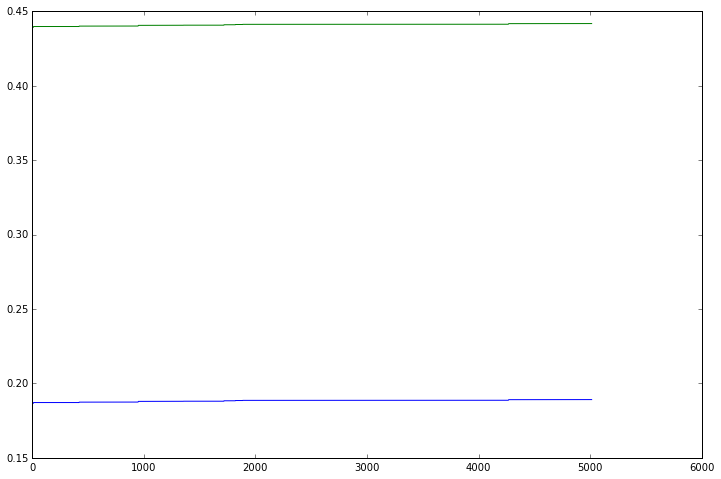

In [189]:
plt.plot(m)

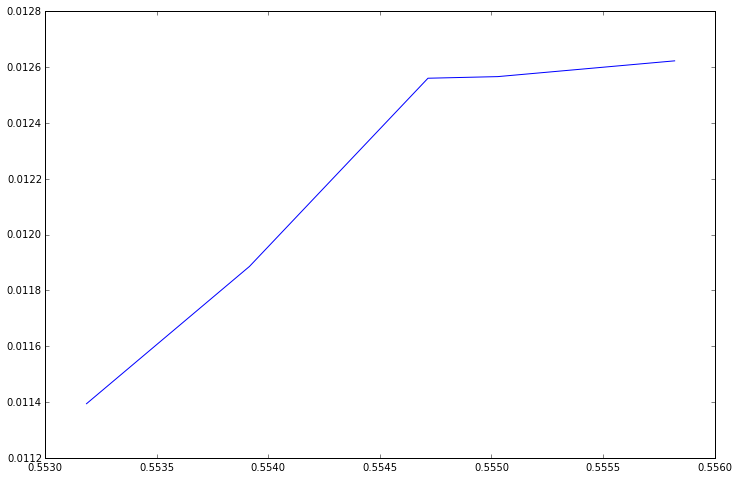

In [185]:
plt.plot(np.array(w).T[0],np.array(s).T[0])

In [186]:
a=np.empty(4)
gmm_param1=gmm_param()
a[1]=[g,gmm_param1.means,gmm_param1.covars,gmm_param1.weights]

ValueError: setting an array element with a sequence.

In [51]:
mean_new    = gmm_param1.means   + m_stepsize*np.random.randn(gmm_param1.means.size)
var_new     = gmm_param1.covars  + m_stepsize*np.random.randn(gmm_param1.covars.size)
weight_new  = gmm_param1.weights + m_stepsize*np.random.randn(gmm_param1.weights.size)
weight_new[-1]=1-(np.sum(weight_new[:-1]))
gmm_new=gmm_param(means=mean_new,covars=var_new, weights=weight_new)

In [70]:
            chain[i]=  g
            for k in range(len(gmm_param1.means)):
                m[i][k]    =  gmm_param1.means[k]
                s[i][k]    =  gmm_param1.covars[k]
                w[i][k]    =  gmm_param1.weights[k]

array([ 0.69975836,  0.10233443,  0.41405599,  0.69440016])

In [ ]:
if ((gmm_param.means > [means_min]*N) and (gmm_param.means < [means_max]*N) and
        (gmm_param.covars > [covars_min]*N) and (gmm_param.covars < [covars_max]*N) and
        (gmm_param.weights > [weights_min]*N) and (gmm_param.weights < [weights_max]*N)):
    